# **Deep Learning-Based Semantic Segmentation for Cell Detection in Biomedical Images**
### Gabriele, Gonçalo, João

what is image segmentation
differences to image classification
types of models 
applications
...
dataset used (https://github.com/sartorius-research/LIVECell)
explain it
...

aims of project

...


In [1]:
import os
import json
import cv2
import numpy as np
from PIL import Image
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras import layers, models

# 1. Path Configuration

base_path = r"C:\Users\gonca\Desktop\LiveCell"

# Annotation files
train_json = os.path.join(base_path, "A172_train.json")
val_json = os.path.join(base_path, "A172_val.json")
test_json = os.path.join(base_path, "A172_test.json")

# Image directories (LiveCell structure)
train_val_image_dir = os.path.join(base_path, "images_A172", "images_train_val")
test_image_dir = os.path.join(base_path, "images_A172", "images_test")

In [21]:
# 2. Data Loading

def load_annotations(json_path, image_dir):
    """Load COCO annotations and map image IDs to full paths"""
    with open(json_path, 'r') as f:
        coco = json.load(f)
    
    image_id_to_path = {
        img['id']: os.path.join(image_dir, img['file_name'])
        for img in coco['images']
    }
    
    annotations_by_image = defaultdict(list)
    for ann in coco['annotations']:
        annotations_by_image[ann['image_id']].append(ann)
        
    return image_id_to_path, annotations_by_image

# Load all splits
train_info, train_anns = load_annotations(train_json, train_val_image_dir)
val_info, val_anns = load_annotations(val_json, train_val_image_dir)
test_info, test_anns = load_annotations(test_json, test_image_dir)

In [7]:
# 3. Mask Generation

def create_mask(annotations, target_size=(256, 256)):
    """Convert polygon annotations to binary mask"""
    mask = np.zeros(target_size, dtype=np.uint8)
    for ann in annotations:
        seg = ann['segmentation']
        if not seg:
            continue
        pts = np.array(seg[0]).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask


In [9]:
# 4. Dataset Preparation

def build_dataset(image_info, annotations_by_image, target_size=(256, 256)):
    """Build numpy arrays of images and masks"""
    images = []
    masks = []
    
    for img_id, img_path in image_info.items():
        # Load and resize image
        img = np.array(Image.open(img_path).convert("L"))
        img = cv2.resize(img, target_size) / 255.0 
        
        mask = create_mask(annotations_by_image[img_id], target_size)
        
        # Add channel dimension
        images.append(np.expand_dims(img, axis=-1))
        masks.append(np.expand_dims(mask, axis=-1))
    
    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

# Build datasets
X_train, y_train = build_dataset(train_info, train_anns)
X_val, y_val = build_dataset(val_info, val_anns)
X_test, y_test = build_dataset(test_info, test_anns)


In [13]:
# 5. U-Net Model

def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    
    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    return models.Model(inputs=[inputs], outputs=[outputs])

In [15]:
# 6. Training

model = unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

# Train
history = model.fit(train_dataset,
                   validation_data=val_dataset,
                   epochs=10)

Epoch 1/10


C:\Users\gonca\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5495 - loss: 0.6876 - val_accuracy: 0.6074 - val_loss: 0.6831
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5560 - loss: 0.6876 - val_accuracy: 0.6074 - val_loss: 0.6681
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5559 - loss: 0.6924 - val_accuracy: 0.6074 - val_loss: 0.6732
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5718 - loss: 0.6853 - val_accuracy: 0.6074 - val_loss: 0.6739
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5504 - loss: 0.6882 - val_accuracy: 0.6074 - val_loss: 0.6705
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5759 - loss: 0.6808 - val_accuracy: 0.6074 - val_loss: 0.6724
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5625 - loss: 0.6853 - val_accuracy: 0.6074 - val_loss: 0.6680
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5628 - loss: 0.6848 - val_accuracy: 0.6074 - val_loss: 0.6769
Epo

In [17]:
# 7. Evaluation

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.6263 - loss: 0.6673

Test Accuracy: 0.6155, Test Loss: 0.6699


C:\Users\gonca\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step


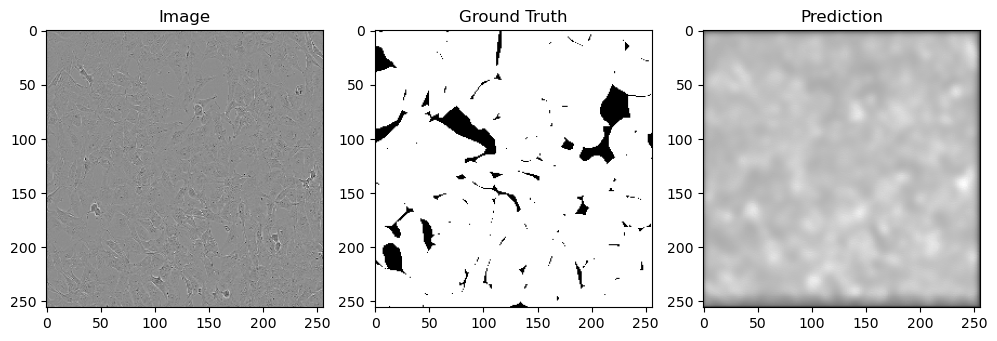

In [19]:
# 8. Visualization

import matplotlib.pyplot as plt

def plot_sample(image, mask, pred_mask=None):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2 if pred_mask is None else 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Image")
    
    plt.subplot(1, 2 if pred_mask is None else 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth")
    
    if pred_mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Prediction")
    
    plt.tight_layout()
    plt.show()

# sample
sample_idx = 0
pred_mask = model.predict(X_test[sample_idx][np.newaxis, ...])[0]
plot_sample(X_test[sample_idx], y_test[sample_idx], pred_mask)



=== Original Model Performance ===
Test Accuracy: 0.6155
Test Loss: 0.6699
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


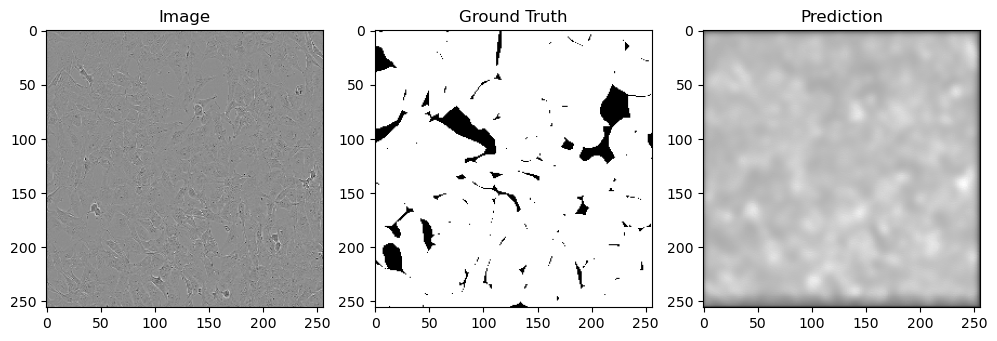

In [23]:
# Evaluation
print("\n=== Original Model Performance ===")
orig_test_loss, orig_test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {orig_test_acc:.4f}")
print(f"Test Loss: {orig_test_loss:.4f}")

sample_idx = 0  
orig_pred = model.predict(X_test[sample_idx][np.newaxis,...])[0]
plot_sample(X_test[sample_idx], y_test[sample_idx], orig_pred)

The test accuracy of 61.55% suggests there's room for improvement.



In [25]:
# Testing with enhanced U-Net with residual connections

def improved_unet(input_size=(256,256,1)):
    inputs = layers.Input(input_size)
    
    def res_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        return layers.Add()([shortcut, x]) if shortcut.shape[-1] == filters else x
    
    x = layers.RandomFlip()(inputs)
    x = layers.RandomRotation(0.1)(x)
    
    d1 = res_block(x, 16)
    p1 = layers.MaxPooling2D()(d1)



    
    
    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(x)
    return models.Model(inputs, outputs)

improved_model = improved_unet()

In [27]:
# Custom Dice Loss func

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred)
    return 1 - (2.*intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred) + smooth)

improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
]

# Train improved model
improved_history = improved_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4192 - loss: 0.4864 - val_accuracy: 0.3926 - val_loss: 0.4761 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4400 - loss: 0.4946 - val_accuracy: 0.3926 - val_loss: 0.4755 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4227 - loss: 0.4877 - val_accuracy: 0.3926 - val_loss: 0.4749 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4402 - loss: 0.4942 - val_accuracy: 0.3926 - val_loss: 0.4743 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4413 - loss: 0.4941 - val_accuracy: 0.3926 - val_loss: 0.4737 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4285 - loss: 0.4884 - val_accuracy: 0.3926 - val_loss: 0.4731 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4359 


=== Improved Model Performance ===
Test Accuracy: 0.3847 (Originally: 0.6155)
Test Loss: 0.4553 (Originally: 0.6699)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


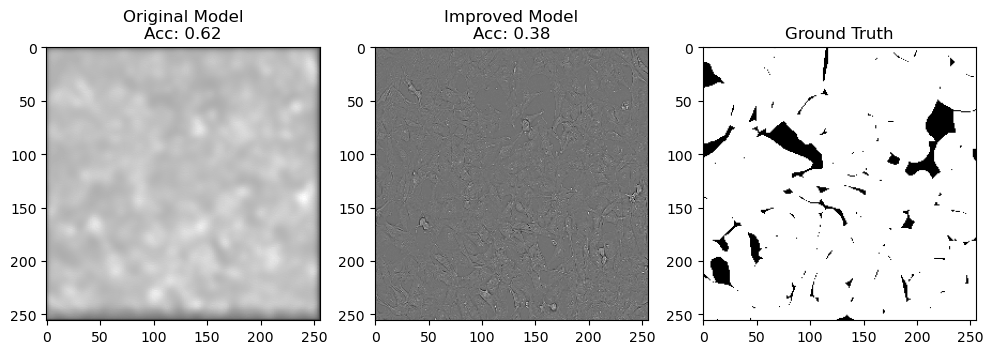

In [29]:
# Evaluate improved model

print("\n=== Improved Model Performance ===")
imp_test_loss, imp_test_acc = improved_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {imp_test_acc:.4f} (Originally: {orig_test_acc:.4f})")
print(f"Test Loss: {imp_test_loss:.4f} (Originally: {orig_test_loss:.4f})")

# Visual comparison
improved_pred = improved_model.predict(X_test[sample_idx][np.newaxis,...])[0]

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(orig_pred.squeeze(), cmap='gray')
plt.title(f"Original Model\nAcc: {orig_test_acc:.2f}")

plt.subplot(1,3,2)
plt.imshow(improved_pred.squeeze(), cmap='gray')
plt.title(f"Improved Model\nAcc: {imp_test_acc:.2f}")

plt.subplot(1,3,3)
plt.imshow(y_test[sample_idx].squeeze(), cmap='gray')
plt.title("Ground Truth")
plt.show()